In [ ]:
#Load the drive helper and mount
from google.colab import drive
#this will prompt for authorization 
drive.mount('/content/drive/')

Mounted at /content/drive/


# Importing Data

Nous utiliserons Parkinson's Drawings téléchargé de kaggle . L'ensemble de données consiste de 204 images de spirales et de vagues enregistrées dans troix dossiers différents, chacun contenant un échantillon de données .

In [ ]:
data_dir ='/content/drive/My Drive/parkinson'

In [ ]:
#librairies
import json
import math
import os
import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical# convert to one-hot-encoding
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter

import itertools
%matplotlib inline
from glob import glob
from keras import Model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tqdm import tqdm_notebook
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import load_model, Model

from skimage.io import imread
from skimage.util import montage as montage2d
from skimage.filters import threshold_yen as thresh_func
from skimage.filters import median
from skimage.morphology import disk
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Data visualization

In [ ]:

train_dir = os.path.join(data_dir, 'training')
test_dir = os.path.join(data_dir, 'testing')
valid_dir = os.path.join(data_dir, 'validating')

In [ ]:
#visualize the classes
classes  = list()
for root, dirs, files in os.walk(train_dir, topdown=False):
    for name in dirs:
        classes.append(os.path.join(name))
print (classes)

['Parkinson', 'Healthy']


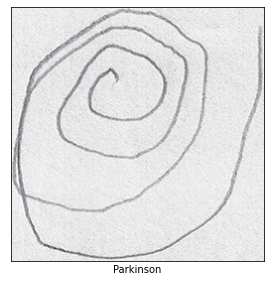

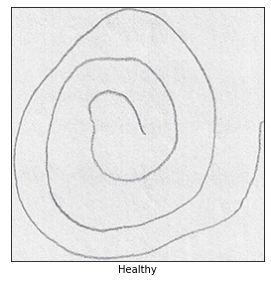

In [ ]:
import matplotlib.image as mpimg
import os 
import glob

for label in classes:
  file_names = os.path.join(data_dir,'training',label,"*.png")
  file_lists = glob.glob(file_names)
  # Read audio file
  img = mpimg.imread(file_lists[0])
  plt.figure(figsize=(10,10))
  plt.subplot(1,2,1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(img)
  plt.xlabel(label)
plt.show()

In [ ]:
#visualize number of training images
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 128 files belonging to 2 classes.


In [ ]:
#visualize number of validation images
valid_dataset = image_dataset_from_directory(valid_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE, image_size=IMG_SIZE)

Found 16 files belonging to 2 classes.


In [ ]:
#visualize number of test images
test_dataset = image_dataset_from_directory(test_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 60 files belonging to 2 classes.


# Data augmentation

In [ ]:

from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
        rescale=1./255, # rescale all pixel values from 0-255, so after this step all our pixel values are in range (0,1)
        shear_range=0.2, #to apply some random tranfromations
        zoom_range=0.2, #to apply zoom
        horizontal_flip=True) # image will be flipper horiztest_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator( rescale = 1.0/255. )
valid_datagen = ImageDataGenerator( rescale = 1.0/255. )

In [ ]:
train_ds = train_datagen.flow_from_directory(
        '/content/drive/My Drive/parkinson/training',
        target_size=(224, 224),
        batch_size=20,
        class_mode='binary',
        shuffle = False)
test_ds = test_datagen.flow_from_directory(
        '/content/drive/My Drive/parkinson/testing',
        target_size=(224, 224),
        batch_size=20,
        class_mode='binary',
        shuffle = False)
valid_ds = valid_datagen.flow_from_directory(
        '/content/drive/My Drive/parkinson/validating',
        target_size=(224, 224),
        batch_size=20,
        class_mode='binary',
        shuffle = False)

Found 128 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


# Transfer Learning 

Création de modèle 

# VGG16 Model

---



Les réseaux convolutionnels très profonds pour la reconnaissance d'images à grande échelle sont l'un des modèles préformés les plus populaires pour la classification des images. Présenté lors de la célèbre conférence ILSVRC 2014, il était et reste encore aujourd'hui LE modèle à battre. Développé au sein du Visual Graphics Group de l'Université d'Oxford, le VGG-16 a battu le standard d'AlexNet de l'époque et a été rapidement adopté par les chercheurs et l'industrie pour leurs tâches de classification d'images.



Chargement du modèle de base

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape = (224, 224, 3), # Shape of our images
                    include_top = False, # Leave out the last fully connected layer
                    weights = 'imagenet')

In [ ]:
for layer in base_model.layers:
      
    layer.trainable = False

In [ ]:
base_model.trainable = False

In [ ]:
base_model.output

<KerasTensor: shape=(None, 7, 7, 512) dtype=float32 (created by layer 'block5_pool')>

In [ ]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)


model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = tf.keras.optimizers.Adam(lr=0.0001), loss = 'binary_crossentropy',metrics = ['acc'])

 la construction du modèle final basé sur les ensembles de formation et de validation que nous avons créés précédemment.

In [ ]:
vgghist = model.fit(train_ds, validation_data = valid_ds, epochs =50)


Epoch 1/50
7/7 [==============================] - 2s 295ms/step - loss: 1.2230 - acc: 0.4453 - val_loss: 0.9493 - val_acc: 0.5000
Epoch 2/50
7/7 [==============================] - 2s 285ms/step - loss: 1.0665 - acc: 0.4453 - val_loss: 0.4703 - val_acc: 0.8750
Epoch 3/50
7/7 [==============================] - 2s 282ms/step - loss: 0.6173 - acc: 0.6172 - val_loss: 0.3671 - val_acc: 1.0000
Epoch 4/50
7/7 [==============================] - 2s 283ms/step - loss: 0.6797 - acc: 0.5781 - val_loss: 0.3431 - val_acc: 1.0000
Epoch 5/50
7/7 [==============================] - 2s 287ms/step - loss: 0.5810 - acc: 0.6875 - val_loss: 0.3159 - val_acc: 0.9375
Epoch 6/50
7/7 [==============================] - 2s 284ms/step - loss: 0.5178 - acc: 0.7656 - val_loss: 0.2498 - val_acc: 1.0000
Epoch 7/50
7/7 [==============================] - 2s 283ms/step - loss: 0.4999 - acc: 0.7031 - val_loss: 0.3124 - val_acc: 0.8750
Epoch 8/50
7/7 [==============================] - 2s 285ms/step - loss: 0.5110 - acc: 0.75

# Evaluation and prediction

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

3/3 [==============================] - 11s 6s/step - loss: 0.3108 - acc: 0.8833
Test accuracy : 0.8833333253860474


Examinons les courbes d'apprentissage de la formation et la précision/perte de validation lors de l'utilisation du modèle de base VGG16.

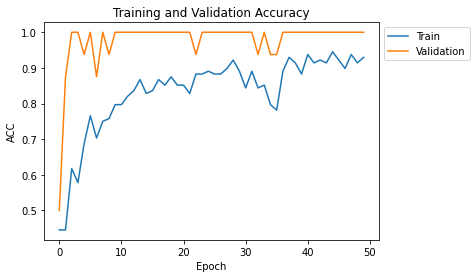

In [ ]:
plt.plot(vgghist.history['acc'])
plt.plot(vgghist.history['val_acc'])
plt.title('Training and Validation Accuracy')
plt.ylabel('ACC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

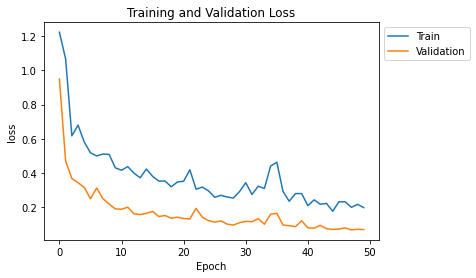

In [ ]:
plt.plot(vgghist.history['loss'])
plt.plot(vgghist.history['val_loss'])
plt.title('Training and Validation Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

# Fine Tuning

Un-freezing the top layers 

In [ ]:

base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 5

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  19


Compiler le modèle 

In [ ]:
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.0001), loss = 'binary_crossentropy',metrics = ['acc'])

In [ ]:
vgghist1 = model.fit(train_ds, validation_data = valid_ds, epochs = 20)


Epoch 1/20
7/7 [==============================] - 8s 519ms/step - loss: 2.5664 - acc: 0.4939 - val_loss: 0.6639 - val_acc: 0.6250
Epoch 2/20
7/7 [==============================] - 2s 300ms/step - loss: 0.7890 - acc: 0.4584 - val_loss: 1.0879 - val_acc: 0.5000
Epoch 3/20
7/7 [==============================] - 2s 304ms/step - loss: 0.6164 - acc: 0.5908 - val_loss: 0.5100 - val_acc: 0.7500
Epoch 4/20
7/7 [==============================] - 2s 332ms/step - loss: 0.6749 - acc: 0.6710 - val_loss: 0.7088 - val_acc: 0.6250
Epoch 5/20
7/7 [==============================] - 2s 301ms/step - loss: 0.4617 - acc: 0.7950 - val_loss: 0.5183 - val_acc: 0.8750
Epoch 6/20
7/7 [==============================] - 2s 297ms/step - loss: 0.2502 - acc: 0.9389 - val_loss: 0.5644 - val_acc: 0.6875
Epoch 7/20
7/7 [==============================] - 2s 301ms/step - loss: 0.4045 - acc: 0.8670 - val_loss: 0.5056 - val_acc: 0.8125
Epoch 8/20
7/7 [==============================] - 2s 304ms/step - loss: 0.2241 - acc: 0.88

Evaluation of the model after fine tuning

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

3/3 [==============================] - 0s 102ms/step - loss: 0.5723 - acc: 0.7333
Test accuracy : 0.7333333492279053


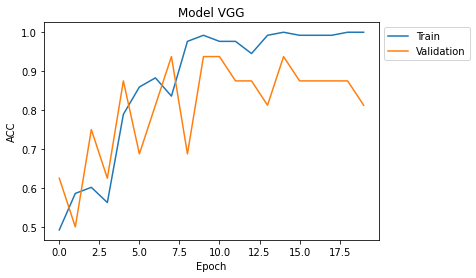

In [ ]:
plt.plot(vgghist1.history['acc'])
plt.plot(vgghist1.history['val_acc'])
plt.title('Model VGG')
plt.ylabel('ACC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

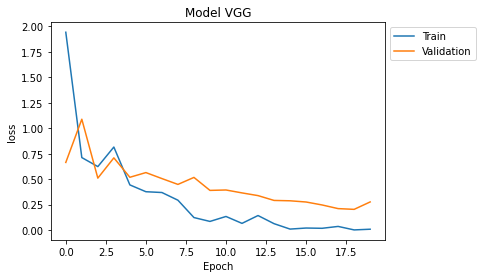

In [ ]:
plt.plot(vgghist1.history['loss'])
plt.plot(vgghist1.history['val_loss'])
plt.title('Model VGG')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

# Second Model InceptionV3


Inception-v3 est une architecture de réseau neuronal convolutif de la famille Inception qui apporte plusieurs améliorations, notamment l'utilisation du lissage d'étiquettes, des convolutions factorisées 7 x 7 et l'utilisation d'un classificateur auxiliaire pour propager les informations d'étiquette plus bas sur le réseau.

Un diagramme général du modèle est présenté ci-dessous :
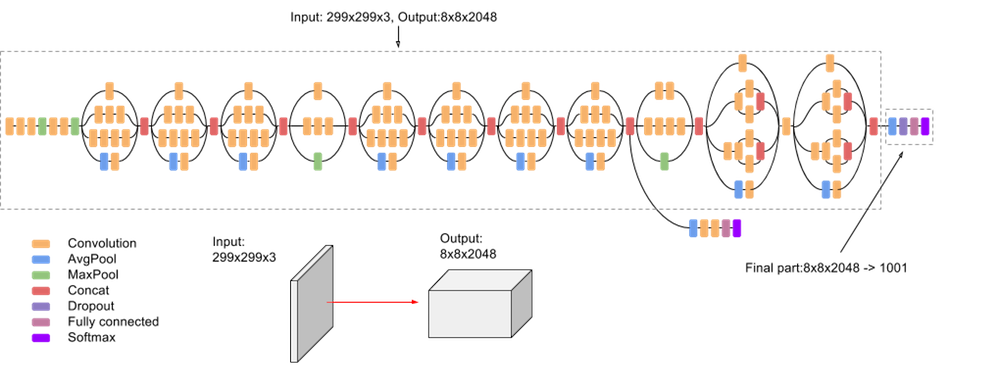


In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
base_model2 = InceptionV3(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')

In [ ]:
from tensorflow.keras.optimizers import Adam
from keras.layers import GlobalAveragePooling2D
from keras.layers import Activation,Dense

out = base_model.output
# Add a global spatial average pooling layer
out = GlobalAveragePooling2D()(out)
# Add a fully connected layer with 512 hidden units and ReLU activation
out = Dense(512, activation='relu')(out)

# Add a final sigmoid layer for classification
predictions = Dense(1, activation='sigmoid')(out)

model = Model(inputs=base_model.input, outputs=predictions)

# only if we want to freeze layers
for layer in base_model.layers:
    layer.trainable = False
    
# Compile 
model.compile(Adam(lr=.0001), loss='binary_crossentropy', metrics=['accuracy']) 

In [ ]:
inc_history = model.fit_generator(train_ds, validation_data = valid_ds, epochs = 50)


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
7/7 [==============================] - 3s 318ms/step - loss: 0.6982 - accuracy: 0.5974 - val_loss: 0.6896 - val_accuracy: 0.5000
Epoch 2/50
7/7 [==============================] - 2s 318ms/step - loss: 0.7189 - accuracy: 0.4487 - val_loss: 0.6461 - val_accuracy: 0.5000
Epoch 3/50
7/7 [==============================] - 2s 286ms/step - loss: 0.6584 - accuracy: 0.5744 - val_loss: 0.6277 - val_accuracy: 0.7500
Epoch 4/50
7/7 [==============================] - 2s 283ms/step - loss: 0.6729 - accuracy: 0.5454 - val_loss: 0.6117 - val_accuracy: 0.8125
Epoch 5/50
7/7 [==============================] - 2s 287ms/step - loss: 0.6555 - accuracy: 0.6767 - val_loss: 0.5937 - val_accuracy: 1.0000
Epoch 6/50
7/7 [==============================] - 2s 287ms/step - loss: 0.6277 - accuracy: 0.8236 - val_loss: 0.5789 - val_accuracy: 1.0000
Epoch 7/50
7/7 [==============================] - 2s 310ms/step - loss: 0.6125 - accuracy: 0.8069 - val_loss: 0.5630 - val_accuracy: 0.9375
Epoch 8/50
7/7 [====

In [ ]:
result = model.evaluate(test_ds)
print("Test-set classification accuracy: {0:.2%}".format(result[1]))

3/3 [==============================] - 0s 116ms/step - loss: 0.3891 - accuracy: 0.8667
Test-set classification accuracy: 86.67%


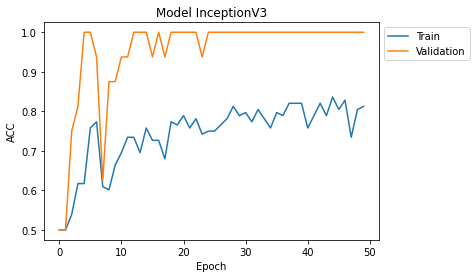

In [ ]:
plt.plot(inc_history.history['accuracy'])
plt.plot(inc_history.history['val_accuracy'])
plt.title('Model InceptionV3')
plt.ylabel('ACC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

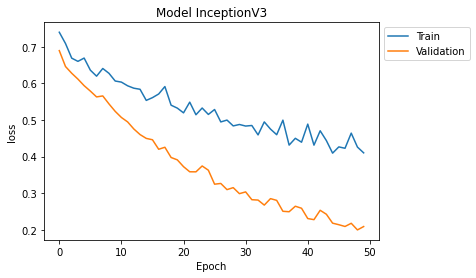

In [ ]:
plt.plot(inc_history.history['loss'])
plt.plot(inc_history.history['val_loss'])
plt.title('Model InceptionV3')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

# Fine Tuning

In [ ]:
base_model2.trainable = True


In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model2.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model2.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  311


In [ ]:
model.compile(tf.keras.optimizers.Adam(lr=0.00001), loss='binary_crossentropy', metrics=['accuracy']) 

In [ ]:
inc_history = model.fit_generator(train_ds, validation_data = valid_ds, epochs = 20)


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
7/7 [==============================] - 9s 549ms/step - loss: 1.2081 - accuracy: 0.5076 - val_loss: 0.4350 - val_accuracy: 0.8125
Epoch 2/20
7/7 [==============================] - 2s 284ms/step - loss: 0.5920 - accuracy: 0.6544 - val_loss: 0.7587 - val_accuracy: 0.6250
Epoch 3/20
7/7 [==============================] - 2s 293ms/step - loss: 0.2247 - accuracy: 0.9158 - val_loss: 0.5306 - val_accuracy: 0.8125
Epoch 4/20
7/7 [==============================] - 2s 290ms/step - loss: 0.1178 - accuracy: 0.9557 - val_loss: 0.3488 - val_accuracy: 0.9375
Epoch 5/20
7/7 [==============================] - 2s 288ms/step - loss: 0.0533 - accuracy: 0.9822 - val_loss: 0.2847 - val_accuracy: 0.8750
Epoch 6/20
7/7 [==============================] - 2s 286ms/step - loss: 0.0379 - accuracy: 0.9884 - val_loss: 0.2591 - val_accuracy: 0.9375
Epoch 7/20
7/7 [==============================] - 2s 322ms/step - loss: 0.0174 - accuracy: 1.0000 - val_loss: 0.2505 - val_accuracy: 0.9375
Epoch 8/20
7/7 [====

In [ ]:
result = model.evaluate(test_ds)
print("Test-set classification accuracy: {0:.2%}".format(result[1]))

3/3 [==============================] - 0s 99ms/step - loss: 0.9195 - accuracy: 0.7000
Test-set classification accuracy: 70.00%


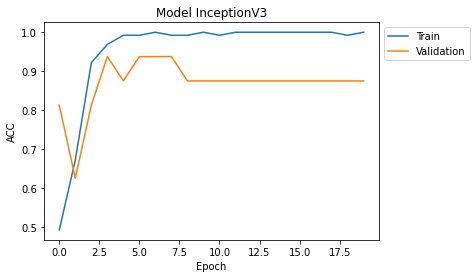

In [ ]:
plt.plot(inc_history.history['accuracy'])
plt.plot(inc_history.history['val_accuracy'])
plt.title('Model InceptionV3')
plt.ylabel('ACC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

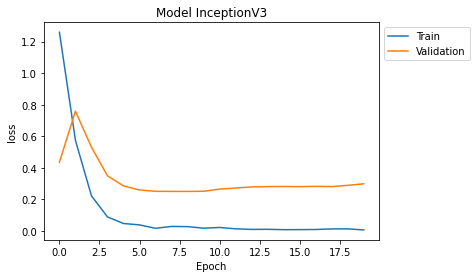

In [ ]:
plt.plot(inc_history.history['loss'])
plt.plot(inc_history.history['val_loss'])
plt.title('Model InceptionV3')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [ ]:
test = tf.data.Dataset.from_generator(lambda:test_ds,(tf.float32, tf.float32))
#Retrieve a batch of images from the test set
image_batch, label_batch = test.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)


Predictions:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Labels:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
